## Calcular el Hand Completo para toda una zona

In [1]:
# ------------------------------------------------------------------------------------------------------------------
# Funcion para crear raster a partir de un array

# Importar todas las  librerías
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

    import gdal, ogr, os, osr
    
    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Int16, ['COMPRESS=DEFLATE','PREDICTOR=2','ZLEVEL=1'])
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.SetNoDataValue(-9999.)  #ensayo
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [2]:
# Importar todas las  librerías

from osgeo import gdal, gdalconst
from pysheds.grid import Grid
import numpy as np
import fnmatch
import glob, os
import shutil
import re
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.colors as colors


In [24]:
%%time
# Ruta absoluta donde están guardados los dems que bajamos para toda la región del USGS. A menos que se quiera
#  procesar una región diferente a las planchas descargadas, este debería quedar por defecto
path_dems = '/opt/geociencia/coreclima/Compartidos/HAND_Region/Procesamiento_DEMs_prueba/1.DEMs_unzip/'

# Ruta donde van a quedar guardados los shapes procesados. El nombre debería ser un argumento de entrada, y debería
# crear la carpeta en caso que no exista el país
out_ruta = '/opt/geociencia/coreclima/Compartidos/HAND_Region/Mexico/'

# Coordenadas del dominio espacial que abarca todas las planchas que componen la región de interés.
# Lat_infer_izq, Lon_infer_izq, Lat_sup_der, Lon_sup_der 
# dominio = '14,-101,21,-95'
# hand_name = 'HAND_N14W101_N21W95'

dominio = '12,-96,23,-85'
hand_name = 'HAND_N12W96_N23W85'

# Extension del archivo que contiene los datos del DEM. Puede ser Tiff, o bil, o ascii, o cualquier formato de estos
extension = 'bil'

# Tamaño del pixel de salida del HAND. Se entra argumento para remuestrear y hacer la salida menos pesada para el
# procesamiento
size_pixel = 200


# ------------------------------------------------------------------------------------------------------------------
# Preprarar la lista con el nombre de los archivos del dominio a procesar
dominio = list(map(float, dominio.split(',')))
os.chdir(path_dems)
file_list = list()
for file in glob.glob('*.' + extension):
    file_list.append(file)
file_list.sort()

processlist = list()

for file in file_list:
    coord = re.findall(r'(\d+)_',file)
    coord = list(map(int, coord))
    lat = re.findall(r'(.)\d+_',file)[0]
    if lat == 's':
        coord[0]=-coord[0]
        
    if (dominio[0]-1 <= coord[0] <= dominio[2]+1 and dominio[1]-1 <= -coord[1] <= dominio[3]+1):
        processlist.append(file)
        

# ------------------------------------------------------------------------------------------------------------------
# Remuestrear los raster del dominio de interés para bajar resolución espacial

for file in processlist:

    inputfile = path_dems+'/'+file
    input_ = gdal.Open(inputfile, gdalconst.GA_ReadOnly)
    inputProj = input_.GetProjection()
    inputTrans = input_.GetGeoTransform()
    bandinput = input_.GetRasterBand(1)  

    # Tamaño de celda en raster original (metros)
    cell_size=inputTrans[1]*111100
    # factor de relación entre tamaño viejo y tamaño nuevo
    factor = int(cell_size)/size_pixel
    f1 = factor*input_.RasterXSize
    ncell = int(f1)
    # factor corregido
    factor_corr = ncell/input_.RasterXSize
    # Resultado
    res = inputTrans[1]/factor_corr

    inputTrans = list(inputTrans)
    inputTrans[1] = res
    inputTrans[-1] = -res
    referenceTrans = tuple(inputTrans)
    x = ncell
    y = ncell


    bandreference = bandinput
    referenceProj = inputProj

    outputfile = out_ruta+file[:-4]+'_resize.tif'
    driver= gdal.GetDriverByName('GTiff')
    output = driver.Create(outputfile,x,y,1,bandreference.DataType)
    output.SetGeoTransform(referenceTrans)
    output.SetProjection(referenceProj)

    gdal.ReprojectImage(input_,output,inputProj,referenceProj,gdalconst.GRA_Bilinear)
    del output

CPU times: user 9.7 s, sys: 1.44 s, total: 11.1 s
Wall time: 16.6 s


In [25]:
# ------------------------------------------------------------------------------------------------------------------
# Hacer el merge de todos los raster remuestreados que quedaron dentro del dominio especificado

search_criteria = "*_resize.tif"
q = os.path.join(out_ruta, search_criteria)
dem_fps = glob.glob(q)

src_files_to_mosaic = []
for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

    
mosaic, out_trans = merge(src_files_to_mosaic)

GT_ET=[out_trans.c, out_trans.a, out_trans.b, out_trans.f, out_trans.d, out_trans.e]

# Guardar el Hand como raster
# GT_ET = inputTrans 
rasterOrigin = (GT_ET[0],GT_ET[3])
pixelWidth = GT_ET[1]
pixelHeight = GT_ET[-1]
newRasterfn = out_ruta+'Resize_completo.tif'
array = mosaic[0,:,:] 
array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array)

for i in dem_fps:
    os.remove(i)


In [26]:
%%time
# ------------------------------------------------------------------------------------------------------------------
# Estimar el HAND del dominio especificado a partir de Pysheds


# Cargar el DEM
grid = Grid.from_raster(out_ruta+'Resize_completo.tif', data_name='dem')
# Fill depressions in DEM
grid.fill_depressions('dem', out_name='flooded_dem')
# Resolve flats in DEM
grid.resolve_flats('flooded_dem', out_name='inflated_dem')
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
# Compute flow directions
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
# Calculate flow accumulation
grid.accumulation(data='dir', dirmap=dirmap, out_name='acc')
# Calcula la red de drenaje
R_drain    = grid.view('acc')
R_drain[R_drain<1000]  = 0
R_drain[R_drain>=1000] = 1
# Calcular Hand
grid.compute_hand('dir', 'dem', R_drain, out_name='hand')
grid.hand[grid.hand<0]  = 0

os.remove(out_ruta+'Resize_completo.tif')

CPU times: user 16min 39s, sys: 43.5 s, total: 17min 23s
Wall time: 17min 23s


In [27]:
# ------------------------------------------------------------------------------------------------------------------
# Guardar el HAND recortandolo para que no quede con los bordes comidos

rasterOrigin = (GT_ET[0],GT_ET[3])
pixelWidth = GT_ET[1]
pixelHeight = GT_ET[-1]
newRasterfn = out_ruta+'HAND_completo.tif'
array = grid.hand
array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array)

In [28]:
projwin = [dominio[1],dominio[2],dominio[3],dominio[0]]

translateoptions = gdal.TranslateOptions(
    gdal.ParseCommandLine('-co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=1'), projWin = projwin)

ds = gdal.Open(out_ruta+'HAND_completo.tif')
ds = gdal.Translate(out_ruta+hand_name+'.tif', ds, options=translateoptions)
ds = None

os.remove(out_ruta+'HAND_completo.tif')

In [48]:
# -------------------------------------------------------------------------------------------------------------------
# Hacer el merge de las planchas hand procesadas

search_criteria = "*.tif"
q = os.path.join(out_ruta, search_criteria)
dem_fps = glob.glob(q)

src_files_to_mosaic = []
for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

    
mosaic, out_trans = merge(src_files_to_mosaic)

GT_ET=[out_trans.c, out_trans.a, out_trans.b, out_trans.f, out_trans.d, out_trans.e]

# Guardar el Hand como raster
# GT_ET = inputTrans 
rasterOrigin = (GT_ET[0],GT_ET[3])
pixelWidth = GT_ET[1]
pixelHeight = GT_ET[-1]
newRasterfn = out_ruta+'Mexico_200m_Python.tif'
array = mosaic[0,:,:] 
array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array)

In [49]:
# Instatiate a grid from a raster
grid = Grid.from_raster(out_ruta+'Mexico_200m_Python.tif', data_name='mexico')

In [54]:
grid.mexico[grid.mexico<0]=0

In [63]:
grid.mexico.shape

(10798, 17275)

In [62]:
grid.extent

(-117.00171347736625, -85.0002340534979, 11.99773251028805, 32.00143569958848)

Text(0, 0.5, 'Latitude')

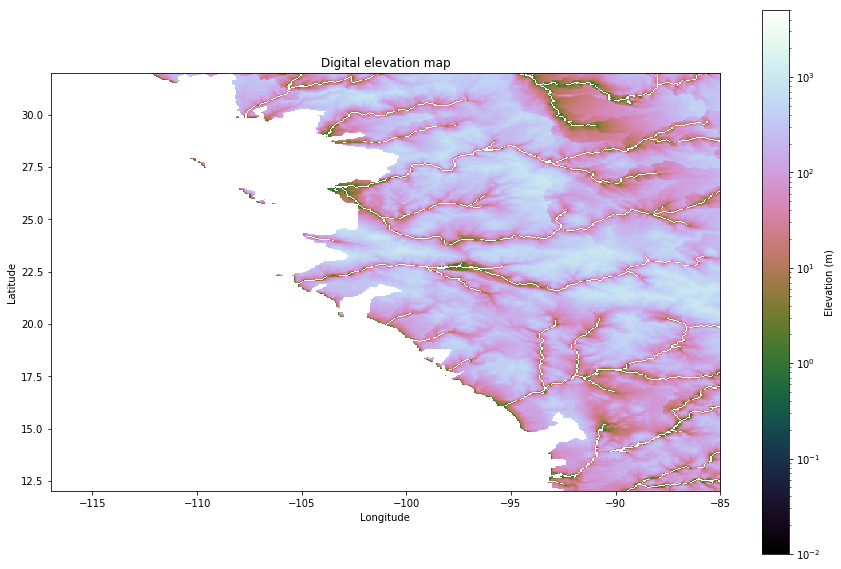

In [64]:
# Plot the raw DEM data
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(grid.mexico[:500,:500], extent=grid.extent, cmap='cubehelix',norm=LogNorm(vmin=0.01, vmax=5000), zorder=1)
plt.colorbar(label='Elevation (m)')
plt.title('Digital elevation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')